In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import (
    recall_score,        # Recall
    precision_score,     # Precision
    f1_score,           # F1-score
    roc_auc_score,      # ROC AUC
    average_precision_score  # PR AUC (Precision-Recall AUC)
)
from sklearn.model_selection import cross_val_score

from anomguard.params import *

from sklearn.model_selection import train_test_split
from anomguard.ml_logic.preprocessing import preprocessing_baseline, preprocessing_V2, preprocessing_V3, preprocessing_V4, preprocessing_V5
from anomguard.ml_logic.model import *
from anomguard.ml_logic.registry import save_results, save_model, load_model
from anomguard.ml_logic.data import load_data_to_bq

In [24]:
data = pd.read_csv('raw_data/creditcard.csv')
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [25]:
MODEL_VERSION

'logistic'

In [26]:
PRE_PROCCESING_VERSION

'V2'

In [27]:
## Performing basic preprocessing
if PRE_PROCCESING_VERSION == "V1":
    X_train_transformed, X_test_transformed, X_val_transformed, y_train, y_test, y_val = preprocessing_baseline(data)

elif PRE_PROCCESING_VERSION == "V2":
    X_train_transformed, X_test_transformed, X_val_transformed, y_train, y_test, y_val = preprocessing_V2(data)

elif PRE_PROCCESING_VERSION == "V3":
    X_train_transformed, X_test_transformed, X_val_transformed, y_train, y_test, y_val = preprocessing_V3(data)

elif PRE_PROCCESING_VERSION == "V4":
    X_train_transformed, X_test_transformed, X_val_transformed, y_train, y_test, y_val = preprocessing_V4(data)

elif PRE_PROCCESING_VERSION == "V5":
    X_train_transformed, X_test_transformed, X_val_transformed, y_train, y_test, y_val = preprocessing_V5(data)

else:
    print("Wrong version selected")


In [28]:
if MODEL_VERSION == "base":
    model = initialize_model()
elif MODEL_VERSION == "logistic":
    model = initialize_logistic()
elif MODEL_VERSION == "xgb":
    model = initialize_xgboost()
elif MODEL_VERSION == "ensemble":
    model = initialize_ensemble()
else:
    model = None


In [29]:
param_dist = {
    "C": [0.01, 0.1, 1],  
    "penalty": ["l2"],
    # "solver": ["saga"],
    "max_iter": [1000]
}


In [ ]:
best_model = LogisticRegression(penalty="l2", C=0.01, max_iter=1000, solver="lbfgs", class_weight="balanced")
best_model


LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)

: 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Используем лучшие параметры из Random Search как базу для Grid Search
param_grid = {
    "C": [0.005, 0.01, 0.05, 0.1],  # Уточняем диапазон C вокруг найденного значения
    "penalty": ["l2"],  # Оставляем только l2
    "max_iter": [1000]  # Фиксируем max_iter, если он не вызывал ConvergenceWarning
}

# Создаём Grid Search
grid_search = GridSearchCV(
    best_model, param_grid, cv=3, scoring="recall", 
    n_jobs=-1, verbose=2
)

# Запускаем подбор параметров
grid_search.fit(X_train_transformed, y_train)

# Выводим лучшие параметры
best_grid_params = grid_search.best_params_
print("Best parameters from Grid Search:", best_grid_params)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [ ]:
best_model = LogisticRegression(C=0.1, max_iter=1000, penalty="l2", solver="lbfgs", class_weight="balanced")
best_model.fit(X_train_transformed, y_train)


LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000)

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, average_precision_score

y_pred = best_model.predict(X_test_transformed)
y_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]  # Вероятности класса 1

# Метрики
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")  # Precision-Recall AUC




Recall: 0.9123
Precision: 0.1361
F1-score: 0.2369
ROC AUC: 0.9844
PR AUC: 0.6977


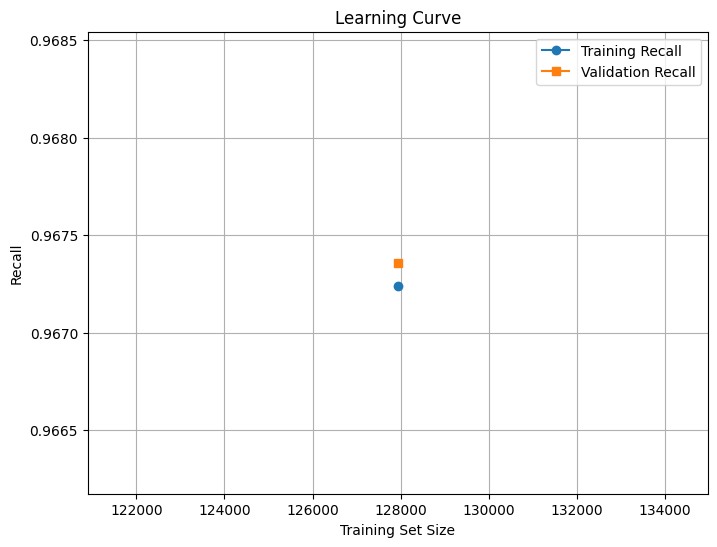

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_transformed, y_train,shuffle=True, cv=2, scoring="recall", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Recall", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, label="Validation Recall", marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Recall")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


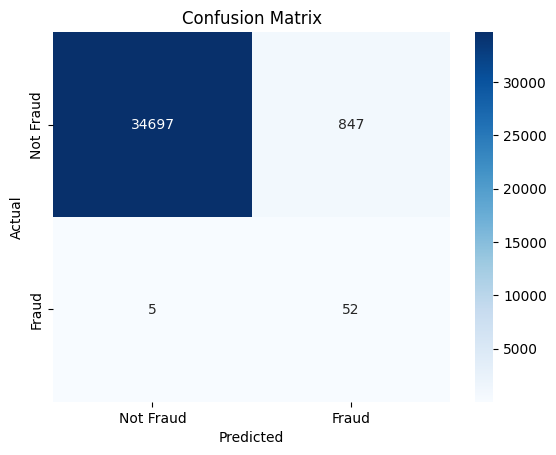

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
